<a href="https://colab.research.google.com/github/Tommy-Las/WatfordFC/blob/main/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and data

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from collections import defaultdict
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
#file_path = '/content/drive/MyDrive/WATFORD FC/Datos GPS/datos_finales_tommy.xlsx'
#file_path = '/content/drive/MyDrive/WATFORD FC/Datos GPS/datos_finales_tommy2.xlsx'
#file_path = 'datos_finales_tommy.xlsx'
#file_path = 'data/cleaned_data.xlsx'
file_path = 'data/cleaned_data_no_injured.xlsx'
# Load the CSV into a DataFrame
df = pd.read_excel(file_path)

# Display the DataFrame
df.head()

,DATE,Microcycle,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,...,>25-21,ACC-21,DEC-21,Sprints-21,Mins-21,Position_CENTREBACK,Position_CENTREMIDFIELDER,Position_FULLBACK,Position_STRIKER,Position_WINGER
0,2021-08-11,M-3,0,2021-2022,SEASON,7423.0,426.0,20,52.0,38.0,...,34,63.0,36.0,19,80.35,0,1,0,0,0
1,2021-08-12,M-2,0,2021-2022,SEASON,1268.0,0.0,0,11.0,5.0,...,54,115.0,74.0,43,171.20,0,1,0,0,0
2,2021-08-13,M-1,0,2021-2022,SEASON,4135.0,112.0,2,47.0,20.0,...,54,126.0,79.0,43,214.78,0,1,0,0,0
3,2021-08-15,M+1,0,2021-2022,SEASON,6379.0,86.0,0,49.0,48.0,...,56,173.0,99.0,54,273.13,0,1,0,0,0
4,2021-08-17,M-4,0,2021-2022,SEASON,6287.0,209.0,9,62.0,44.0,...,56,222.0,147.0,67,352.61,0,1,0,0,0


Chequear desbalanceo de clases

In [3]:
print("No Lesión: " + str(df[df["Injury"] == 0].shape[0]))
print("Lesión: " + str(df[df["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((df[df['Injury'] == 1].shape[0] / df.shape[0]) * 100):.2f}%")

No Lesión: 4663
Lesión: 37
Porcentaje de lesionados en el dataset: 0.79%


# Initialize metrics

In [9]:
metrics = ['TD', '>19.8',
       '>25', 'ACC', 'DEC', 'Sprints']

# Correlation of variables

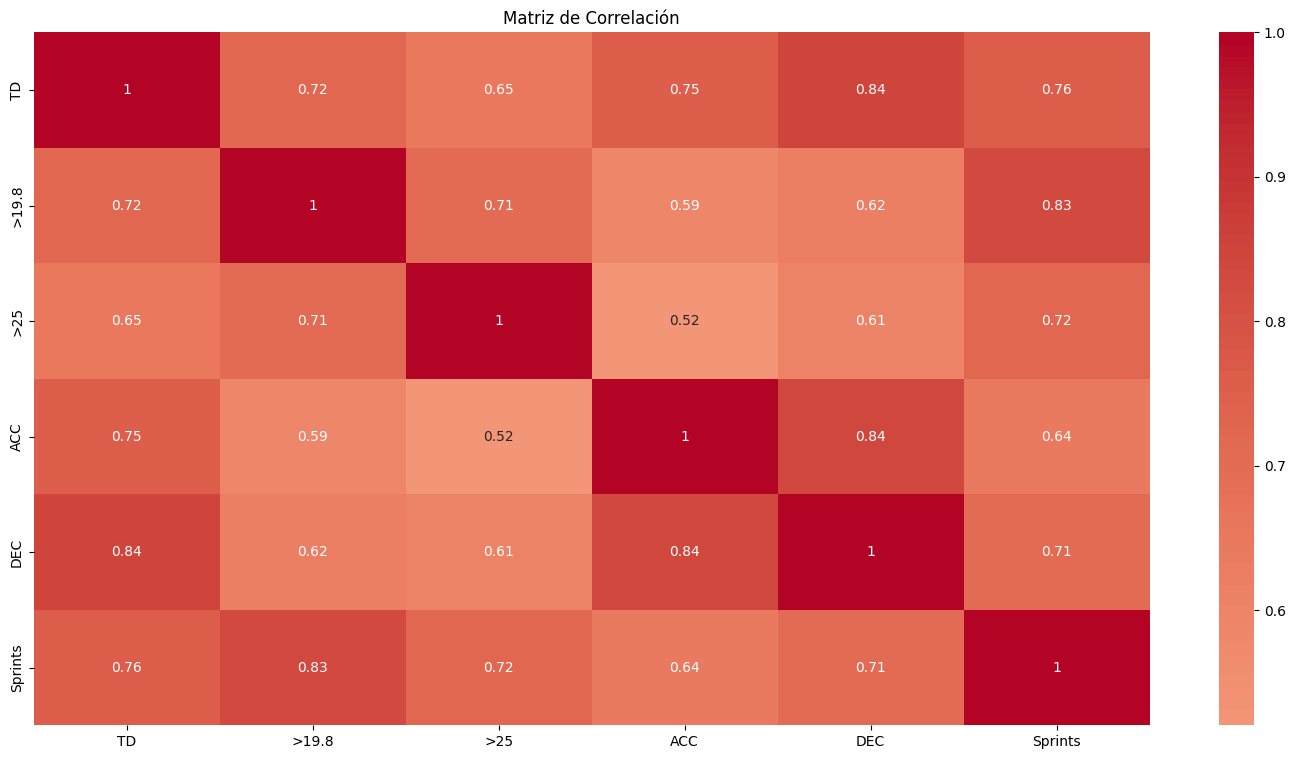

In [10]:
# Calcular la matriz de correlación
correlation_matrix = df[metrics].corr()

# Mostrar la matriz de correlación
plt.figure(figsize=(18, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


In [11]:
df_with_constant = add_constant(df[metrics])

# Calcular el VIF para cada columna
vif_data = pd.DataFrame()
vif_data["Variable"] = df_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                   for i in range(df_with_constant.shape[1])]

# Mostrar el VIF
print(vif_data)

  Variable       VIF
0    const  7.536370
1       TD  4.628723
2    >19.8  3.719300
3      >25  2.396270
4      ACC  3.594287
5      DEC  5.476943
6  Sprints  4.365045


## Filtrar datos por fecha o temporada


In [4]:
df.season.unique()

array(['2021-2022', '2022-2023'], dtype=object)

In [19]:
# df_filtered = df[df.season == '2022-2023'].reset_index(drop=True)
df_filtered = df.copy()

In [20]:
df_filtered = df_filtered[df_filtered['preseason-season'] != 'PRESEASON']

df_filtered.reset_index(drop=True, inplace=True)

# ML Modelos

In [21]:
df_filtered.head()

,DATE,Microcycle,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,...,>25-21,ACC-21,DEC-21,Sprints-21,Mins-21,Position_CENTREBACK,Position_CENTREMIDFIELDER,Position_FULLBACK,Position_STRIKER,Position_WINGER
0,2021-08-11,M-3,0,2021-2022,SEASON,7423.0,426.0,20,52.0,38.0,...,34,63.0,36.0,19,80.35,0,1,0,0,0
1,2021-08-12,M-2,0,2021-2022,SEASON,1268.0,0.0,0,11.0,5.0,...,54,115.0,74.0,43,171.20,0,1,0,0,0
2,2021-08-13,M-1,0,2021-2022,SEASON,4135.0,112.0,2,47.0,20.0,...,54,126.0,79.0,43,214.78,0,1,0,0,0
3,2021-08-15,M+1,0,2021-2022,SEASON,6379.0,86.0,0,49.0,48.0,...,56,173.0,99.0,54,273.13,0,1,0,0,0
4,2021-08-17,M-4,0,2021-2022,SEASON,6287.0,209.0,9,62.0,44.0,...,56,222.0,147.0,67,352.61,0,1,0,0,0


## Separate data into X, y and player_ids

In [8]:
df_filtered.columns

Index(['DATE', 'Microcycle', 'Injury', 'season', 'preseason-season', 'TD',
       '>19.8', '>25', 'ACC', 'DEC', 'PlayerID', 'Max Speed', 'Sprints',
       'Mins', 'Max Speed Season', 'Avg Speed Season', '% Max Speed',
       'Speed Diff Max Avg', 'TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3',
       'Sprints-3', 'Mins-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7',
       'Sprints-7', 'Mins-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21', 'Mins-21', 'Position_CENTREBACK',
       'Position_CENTREMIDFIELDER', 'Position_FULLBACK', 'Position_STRIKER',
       'Position_WINGER'],
      dtype='object')

In [22]:
# metrics = ['TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3',
#        'Sprints-3', 'Mins-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7',
#        'Sprints-7', 'Mins-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21', 'Mins-21', 'Position_CENTREBACK',
#        'Position_CENTREMIDFIELDER', 'Position_FULLBACK', 'Position_STRIKER',
#        'Position_WINGER']

metrics_train = ['TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3',
       'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7',
       'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21']

# metrics_train = ['TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3',
#        'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7',
#        'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21']

# metrics_train = ['TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3',
#        'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7',
#        'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21']

print(len(metrics_train))

18


In [23]:
metrics_df = ['DATE', 'PlayerID', 'Injury', 'TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3',
       'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7',
       'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21']

df_sorted = df_filtered[metrics_df].sort_values(by='DATE', ascending=False)

In [12]:
# Define the cutoff date
cutoff_date = pd.Timestamp('2023-02-08')

# Split into training and testing sets
train_df = df_sorted[df_sorted['DATE'] < cutoff_date]
test_df = df_sorted[df_sorted['DATE'] >= cutoff_date]

# Reset index for training and testing sets
X_train = train_df[metrics_train].reset_index(drop=True)
y_train = train_df['Injury'].reset_index(drop=True)
X_test = test_df[metrics_train].reset_index(drop=True)
y_test = test_df['Injury'].reset_index(drop=True)
extra_cols_test = test_df[['DATE', 'PlayerID']].reset_index(drop=True)

In [24]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

## Split data

In [25]:
# Split the data into training and test sets
# X_train, X_test, y_train, y_test, player_ids_train, player_ids_test = train_test_split(X, y, player_ids, test_size=0.3, random_state=42, stratify=y)
X_train, X_test, y_train, y_test, extra_cols_train, extra_cols_test = train_test_split(X, y, extra_cols, test_size=0.3, random_state=42)

## Smote

In [15]:
# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_train , y_train = smote.fit_resample(X_train, y_train)

# smote_enn = SMOTEENN(random_state=42)
# X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts())

Class distribution after SMOTE:
Injury
0    1708
1    1708
Name: count, dtype: int64
Injury
0    1708
1    1708
Name: count, dtype: int64


## Logistic Regression

In [31]:
# Create the model
logistic_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
logistic_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = logistic_model.predict(X_train_scaled)
y_test_pred = logistic_model.predict(X_test_scaled)

# Probabilities
y_test_prob = logistic_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

# Training evaluation
print("Training Set Evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# Test evaluation
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Training Set Evaluation:
Accuracy: 0.6631033365727244
Confusion Matrix:
 [[2029 1033]
 [   7   18]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.66      0.80      3062
           1       0.02      0.72      0.03        25

    accuracy                           0.66      3087
   macro avg       0.51      0.69      0.41      3087
weighted avg       0.99      0.66      0.79      3087


Test Set Evaluation:
Accuracy: 0.6586102719033232
Confusion Matrix:
 [[865 448]
 [  4   7]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.66      0.79      1313
           1       0.02      0.64      0.03        11

    accuracy                           0.66      1324
   macro avg       0.51      0.65      0.41      1324
weighted avg       0.99      0.66      0.79      1324



Number of unique thresholds: 27

Optimal Threshold: 0.51

Evaluation with Optimal Threshold:
Accuracy: 0.6842900302114804
Confusion Matrix:
 [[899 414]
 [  4   7]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.68      0.81      1313
           1       0.02      0.64      0.03        11

    accuracy                           0.68      1324
   macro avg       0.51      0.66      0.42      1324
weighted avg       0.99      0.68      0.80      1324



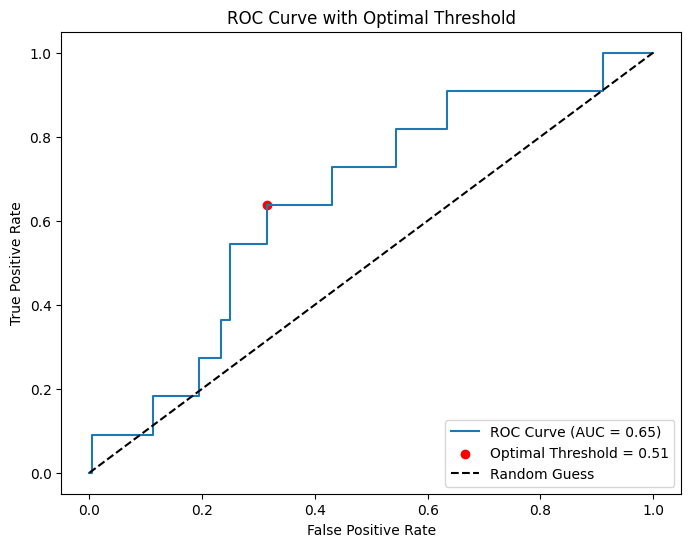

In [32]:
# ROC curve and optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

# Check unique thresholds
print(f"Number of unique thresholds: {len(thresholds)}")

# Find the optimal threshold
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal Threshold: {optimal_threshold:.2f}")

# Apply the optimal threshold
y_test_pred_optimal = (y_test_prob >= optimal_threshold).astype(int)

# Evaluate with the optimal threshold
print("\nEvaluation with Optimal Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_optimal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_optimal))
print("Classification Report:\n", classification_report(y_test, y_test_pred_optimal))

# Plot the ROC curve with the optimal threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color="red", label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Optimal Threshold")
plt.legend(loc="lower right")
plt.show()

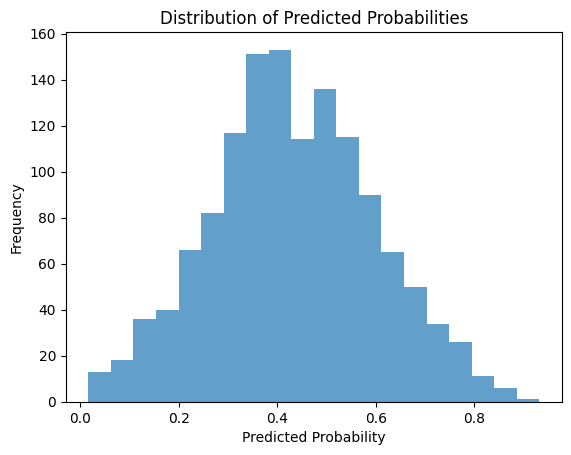

In [33]:
plt.hist(y_test_prob, bins=20, alpha=0.7)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

In [34]:
extra_cols_test.reset_index(inplace=True, drop=True)

df_a = pd.DataFrame({
    'Player': extra_cols_test['PlayerID'],
    'Date': extra_cols_test['DATE'],
    'Score': y_test_prob,
    'Actual': y_test.reset_index(drop=True)
})

# Display the resulting DataFrame
print("\nPlayer, Date, Score, and Actual DataFrame:")
df_a.head()


Player, Date, Score, and Actual DataFrame:


,Player,Date,Score,Actual
0,12086,2022-07-27,0.785543,0
1,50832,2022-04-10,0.539836,0
2,10103,2021-12-08,0.138968,0
3,37709,2022-08-14,0.168661,0
4,89871,2023-04-24,0.480652,0


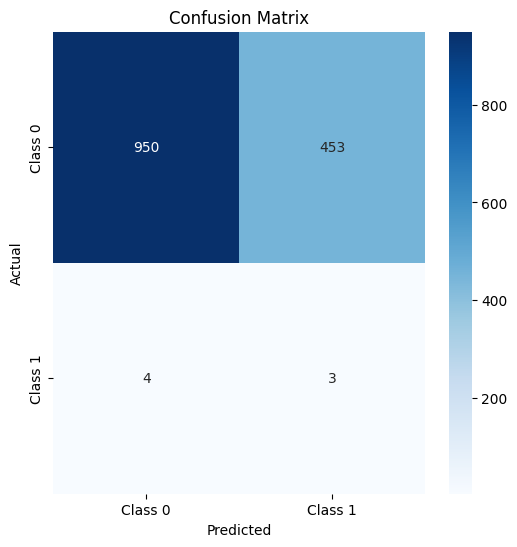

In [188]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [189]:
# Assuming your features are in a DataFrame
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,  # Replace with your feature names
    "Importance": logistic_model.coef_[0]  # Coefficients from logistic regression
})

# Sort by importance
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Display the feature importance
print(feature_importance)

       Feature  Importance
11   Sprints-7    5.418981
0         TD-3    3.276942
14      >25-21    3.128213
13    >19.8-21    2.593718
4        DEC-3    1.907081
15      ACC-21    1.818959
6         TD-7    1.269034
9        ACC-7    0.967611
2        >25-3    0.911069
8        >25-7    0.373886
12       TD-21   -0.364082
16      DEC-21   -0.563353
7      >19.8-7   -0.720388
10       DEC-7   -1.566159
3        ACC-3   -2.214967
5    Sprints-3   -3.468224
17  Sprints-21   -5.895910
1      >19.8-3   -6.103637


In [190]:
# Extract top features by absolute importance
num_top_features = 15  # Adjust this to include the number of features you want
top_features = feature_importance.iloc[:num_top_features]["Feature"].values

print(f"Selected Top {num_top_features} Features: {top_features}")

Selected Top 15 Features: ['Sprints-7' 'TD-3' '>25-21' '>19.8-21' 'DEC-3' 'ACC-21' 'TD-7' 'ACC-7'
 '>25-3' '>25-7' 'TD-21' 'DEC-21' '>19.8-7' 'DEC-7' 'ACC-3']


In [194]:
# Filter the training and testing data for top features
X_train_top = X_train_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]
X_test_top = X_test_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]

# Train logistic regression with top features
logistic_model_top = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
logistic_model_top.fit(X_train_top, y_train)

# Predictions
y_test_pred_top = logistic_model_top.predict(X_test_top)

# Evaluate performance
print("Updated Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_top))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_top))
print("Classification Report:\n", classification_report(y_test, y_test_pred_top))

Updated Model Evaluation:
Accuracy: 0.6510638297872341
Confusion Matrix:
 [[914 489]
 [  3   4]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.65      0.79      1403
           1       0.01      0.57      0.02         7

    accuracy                           0.65      1410
   macro avg       0.50      0.61      0.40      1410
weighted avg       0.99      0.65      0.78      1410



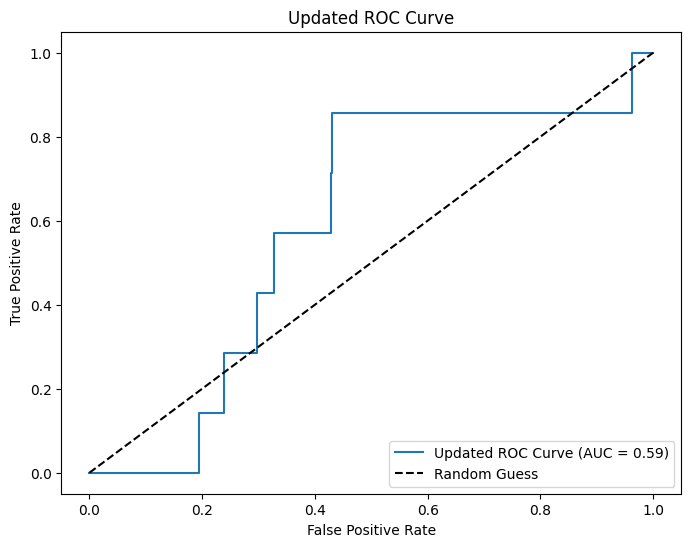

In [193]:
# Get probabilities for the updated model
y_test_probs_top = logistic_model_top.predict_proba(X_test_top)[:, 1]

# Calculate and plot ROC curve for the updated model
fpr_top, tpr_top, _ = roc_curve(y_test, y_test_probs_top)
roc_auc_top = auc(fpr_top, tpr_top)

plt.figure(figsize=(8, 6))
plt.plot(fpr_top, tpr_top, label=f"Updated ROC Curve (AUC = {roc_auc_top:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Updated ROC Curve")
plt.legend(loc="lower right")
plt.show()

## SVM

In [ ]:
# Split data into train/validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train_val_scaled, y_train_val)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['rbf', 'poly'],
    'class_weight': ['balanced', {0: 1, 1: 10}]
}

# Initialize the SVM model
svm_model = SVC(probability=True, random_state=42)

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=3)
grid_search.fit(X_resampled, y_resampled)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

# Use the best estimator for testing
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("Test Set AUC:", roc_auc)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.75      0.85       789
           1       0.13      0.77      0.22        39

    accuracy                           0.75       828
   macro avg       0.56      0.76      0.54       828
weighted avg       0.94      0.75      0.82       828

Test Set AUC: 0.8024763576094374


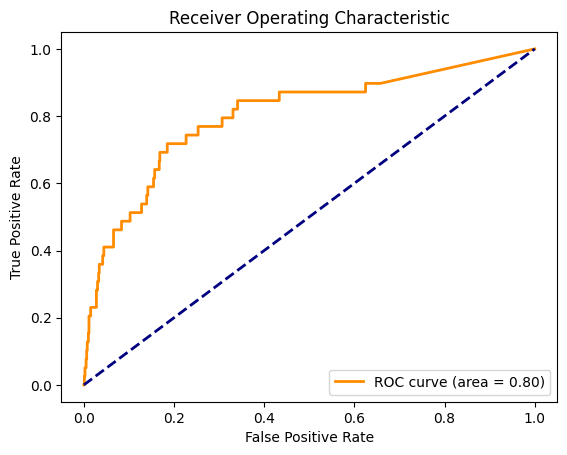

In [192]:
# Split data into train/validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train_val_scaled, y_train_val)

# # SMOTE for oversampling the training data
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X_train_val_scaled, y_train_val)

# Train the SVM model
svm_model = SVC(kernel='rbf', class_weight={0: 1, 1: 10}, C=0.5, gamma=0.1, probability=True, random_state=42)
svm_model.fit(X_resampled, y_resampled)

# Evaluate on the test set
y_pred = svm_model.predict(X_test_scaled)
y_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("Test Set AUC:", roc_auc)

# Plot ROC Curve (optional)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## XGBoost Model

Perform Recursive Feature Elimination with Cross-Validation (RFECV) to find the best variables

Use GridSearch to find the best hyperparameters

In [67]:
# Base parameters for XGBClassifier
base_params = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.8,  # Feature subsampling
    'subsample': 0.8,         # Row subsampling
    'eval_metric': 'auc',
    'alpha': 5,              # L1 regularization
    'gamma': 5,              # Minimum loss reduction
    'max_depth': 3,
    'learning_rate': 0.09,
    'n_estimators': 100
}

# Initialize the XGBClassifier
rfe_model = XGBClassifier(**base_params)

# Perform RFE for feature selection
rfe = RFE(
    estimator=rfe_model,
    n_features_to_select=8,  # Select exactly X features
    step=1  # Remove one feature at a time
)

# Fit RFE to X_train
rfe.fit(X_train, y_train)

# Get selected feature names
selected_features = X_train.columns[rfe.support_]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Selected Features (RFE): {selected_features.tolist()}")
print(f"Number of features selected: {len(selected_features)}")

Selected Features (RFE): ['ACC-21', '>19.8-3', 'TD-7', '>25-21', 'ACC-3', '>25-3', 'DEC-7', 'TD-21']
Number of features selected: 8


In [19]:
# Updated base parameters with added regularization
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,        
    'colsample_bytree': 0.8 
}

# Expanded parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.07, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [200, 300, 400],
    'scale_pos_weight': [10,12,15],
    'alpha': [0, 1, 5],
    'gamma': [0, 1, 5],
}

# scaler = StandardScaler()
# X_train_selected = scaler.fit_transform(X_train_selected)
# X_test_selected = scaler.transform(X_test_selected)

model = XGBClassifier(**base_params_xgboost)

# Stratified K-Fold Cross-Validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',  # Optimize for ROC-AUC
    cv=stratified_cv,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the training dataset
grid_search.fit(X_train_selected, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_roc_auc = grid_search.best_score_

# Print best results
print(f"Best ROC-AUC (Grid Search): {best_roc_auc:.4f}")
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


KeyboardInterrupt: 

## Train the model with the best parameters

In [74]:
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,        
    'colsample_bytree': 0.8 
}

param_grid = {
   'learning_rate': 0.07,  # Explore smaller learning rates
   'max_depth': 11,             # Test broader depth values
   'n_estimators': 400,     # Include larger estimators
   'scale_pos_weight': 9,
   'alpha': 0,  # L1 regularization
   'gamma': 0,  # Minimum loss reduction
}


# Train the final model
final_model = XGBClassifier(
    **base_params_xgboost,
    **param_grid,
)

# Train
final_model.fit(X_train_selected,
                y_train,
                verbose=True
)

# Predict class labels (0 or 1) on the test set
y_pred_probs = final_model.predict_proba(X_test_selected)[:, 1]
# Apply custom threshold
threshold = 0.50
y_pred = (y_pred_probs >= threshold).astype(int)
test_roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"Final Test ROC-AUC: {test_roc_auc:.4f}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Final Test ROC-AUC: 0.5386
Accuracy: 0.9381
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[1242   71]
 [  11    0]]


## Transform test data

In [205]:
X_test = X_test_selected.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
player_ids_test = player_ids_test.reset_index(drop=True)

In [206]:
def categorize_risk(percentage):
    if percentage < 40:
        return 'Low Risk'
    elif 40 <= percentage < 70:
        return 'Medium Risk'
    else:
        return 'High Risk'

# Evaluate the best model on the test set
y_probs = final_model.predict_proba(X_test_selected)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_probs)

print(f"Test ROC-AUC: {test_roc_auc:.4f}")

# Convert the probabilities of injury risk (Class 1) to percentages
injury_risk_percentage = y_probs * 100

# Categorize the injury risk percentages
risk_levels = [categorize_risk(percentage) for percentage in injury_risk_percentage]

# Create the `results` DataFrame with only relevant metrics and calculated values
results = pd.DataFrame({
    'Player_ID': player_ids_test,  # Add player IDs
    'Actual_Label': y_test,  # Add actual labels
    '%': injury_risk_percentage,
    'Risk_Level': risk_levels
}).join(X_test[['TD-7', '+25 Km/h-7', 'ACC-7', 'DEC-7', 'Sprints-7']])  # Add only relevant metrics



Test ROC-AUC: 0.8348


In [207]:
# Define risk level colors
color_mapping = {
    'High Risk': 'FF9999',  # Light Red
    'Medium Risk': 'FFFF99',  # Light Yellow
    'Low Risk': '99FF99'  # Light Green
}

# file_path_export = '/content/drive/MyDrive/WATFORD FC/Datos GPS/results.xlsx'
file_path_export = 'results.xlsx'

wb = Workbook()

# Write `results` to the first sheet
ws = wb.active
ws.title = "Injury Risk Results"
for r_idx, row in enumerate(dataframe_to_rows(results, index=True, header=True), start=1):
    for c_idx, value in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)

# Conditional formatting for `results`
risk_level_col_idx = list(results.columns).index("Risk_Level") + 2
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=risk_level_col_idx, max_col=risk_level_col_idx):
    for cell in row:
        risk_level = cell.value
        if risk_level in color_mapping:
            cell.fill = PatternFill(start_color=color_mapping[risk_level], end_color=color_mapping[risk_level], fill_type="solid")

# Save the workbook
wb.save(file_path_export)

In [ ]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

def mrmr_manual_regression(X, y, num_features):
    selected_features = []
    remaining_features = list(range(X.shape[1]))
    
    # Calculate mutual information for relevance (regression)
    relevance = mutual_info_regression(X, y)
    
    for _ in range(num_features):
        scores = []
        for feature in remaining_features:
            # Calculate redundancy with already selected features
            redundancy = np.mean([mutual_info_regression(X[:, feature].reshape(-1, 1), X[:, sel]) 
                                  for sel in selected_features]) if selected_features else 0
            
            # mRMR score = relevance - redundancy
            score = relevance[feature] - redundancy
            scores.append((feature, score))
        
        # Select the feature with the maximum score
        best_feature = max(scores, key=lambda x: x[1])[0]
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
    
    return selected_features

selected_features_indexes = mrmr_manual_regression(X.values, y.values, 8)

feature_names = X.columns  # Assuming X is a pandas DataFrame
selected_feature_names = [feature_names[i] for i in selected_features_indexes]

print("Selected Features:", selected_feature_names)

X = X[selected_feature_names]